## IMPORT LIBRARY AND DATA

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_val_predict

In [2]:
ar = pd.read_csv("application_record.csv")
cr = pd.read_csv("credit_record.csv")

## DATA PREPARATION


In [3]:
ar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [4]:
cr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


#### Add New Calculated Column

In [5]:
ar["AGE"] = (ar.DAYS_BIRTH * -1) // 365

In [6]:
ar = ar.replace(365243,0)

In [7]:
ar["WORKING_YEAR"] = np.where(((ar.DAYS_EMPLOYED) > -365) & ((ar.DAYS_EMPLOYED) < 0), 
                              1, (ar.DAYS_EMPLOYED * -1) // 365)

#### Handling Missing Value 

In [8]:
ar['OCCUPATION_TYPE'] = np.where((ar['OCCUPATION_TYPE'].isnull()) & (ar['WORKING_YEAR'] == 0), 
                                 'Not working', ar['OCCUPATION_TYPE'])

In [9]:
ar['OCCUPATION_TYPE'] = ar['OCCUPATION_TYPE'].replace(np.nan,'Others')

#### Data Transformation

In [10]:
ar.CODE_GENDER = ar.CODE_GENDER.map({"F":0,"M":1})
ar.FLAG_OWN_CAR = ar.FLAG_OWN_CAR.map({"N":0,"Y":1})
ar.FLAG_OWN_REALTY = ar.FLAG_OWN_REALTY.map({"N":0,"Y":1})

In [11]:
features = ['NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']

for col in features:
    le = preprocessing.LabelEncoder()
    ar[col] = le.fit_transform(ar[col].values)

In [12]:
cr.STATUS = cr.STATUS.map({"X":1,"C":1, "0":1, "1":0, "2":0, "3":0, "4":0, "5":0})

In [13]:
grouped = cr.groupby('ID')
pivot_tb = cr.pivot(index = 'ID', columns = 'MONTHS_BALANCE', values = 'STATUS')

#### Status Classification

In [14]:
#Counting number of good and bad record.
pivot_tb['GOOD'] = pivot_tb[pivot_tb.iloc[:,0:61] == 1].count(axis = 1)
pivot_tb['BAD'] = pivot_tb[pivot_tb.iloc[:,0:61] == 0].count(axis = 1)

In [15]:
pivot_tb.reset_index(inplace=True)

In [16]:
pivot_tb['STATUS'] = np.where(((pivot_tb['GOOD'] < pivot_tb['BAD']) | (pivot_tb[0] == 0) 
                               | (pivot_tb[-1] == 0) | (pivot_tb[-2] == 0)), 0, 1)

#### Join Table

In [17]:
datacredit = ar.merge(pivot_tb, how='inner', on=['ID'])

In [18]:
datacredit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 36456
Data columns (total 84 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   CODE_GENDER          36457 non-null  int64  
 2   FLAG_OWN_CAR         36457 non-null  int64  
 3   FLAG_OWN_REALTY      36457 non-null  int64  
 4   CNT_CHILDREN         36457 non-null  int64  
 5   AMT_INCOME_TOTAL     36457 non-null  float64
 6   NAME_INCOME_TYPE     36457 non-null  int32  
 7   NAME_EDUCATION_TYPE  36457 non-null  int32  
 8   NAME_FAMILY_STATUS   36457 non-null  int32  
 9   NAME_HOUSING_TYPE    36457 non-null  int32  
 10  DAYS_BIRTH           36457 non-null  int64  
 11  DAYS_EMPLOYED        36457 non-null  int64  
 12  FLAG_MOBIL           36457 non-null  int64  
 13  FLAG_WORK_PHONE      36457 non-null  int64  
 14  FLAG_PHONE           36457 non-null  int64  
 15  FLAG_EMAIL           36457 non-null 

In [19]:
del datacredit["DAYS_BIRTH"]
del datacredit["DAYS_EMPLOYED"]

In [20]:
datacredit.drop(datacredit.iloc[:, -64:-1], inplace=True, axis=1)

In [21]:
# datacredit = datacredit.drop(['ID', 'FLAG_MOBIL'], axis=1)
datacredit = datacredit.drop(['ID', 'FLAG_MOBIL', 'FLAG_EMAIL', 'CODE_GENDER', 'CNT_CHILDREN', 
                              'NAME_HOUSING_TYPE', 'FLAG_WORK_PHONE', 'CNT_FAM_MEMBERS','FLAG_OWN_CAR', 
                              'FLAG_OWN_REALTY', 'FLAG_PHONE', 'NAME_INCOME_TYPE'], axis=1)

#### Drop Duplicate

In [22]:
datacredit = datacredit.drop_duplicates()

In [23]:
datacredit.groupby('STATUS').size()

STATUS
0     603
1    8822
dtype: int64

In [24]:
#plt.figure(figsize=(18, 8))
#heatmap = sns.heatmap(datacredit.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
#heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':10}, pad=12);
#plt.show()

In [25]:
datacredit

,AMT_INCOME_TOTAL,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,OCCUPATION_TYPE,AGE,WORKING_YEAR,STATUS
0,427500.0,1,0,13,32,12,1
2,112500.0,4,1,18,58,3,1
3,270000.0,4,3,16,52,8,1
7,283500.0,1,2,12,61,0,1
10,270000.0,1,1,0,46,2,1
...,...,...,...,...,...,...,...
36445,112500.0,4,1,13,43,7,1
36452,315000.0,4,1,10,47,6,0
36453,157500.0,1,1,11,33,3,0
36455,283500.0,4,1,16,49,1,0


## MODELING

In [26]:
X = datacredit.drop(['STATUS'],axis=1)
y = datacredit.STATUS

In [27]:
# #over sampling, imbalanced data
ros = RandomOverSampler(random_state=0)
X_res, y_res = ros.fit_resample(X,y)
y_res.value_counts()

1    8822
0    8822
Name: STATUS, dtype: int64

In [28]:
# split untuk oversampling
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=0)

#### MODEL 1 -- LOGISTIC REGRESSION

In [29]:
model1 = LogisticRegression()
model1.fit(X_train, y_train)
y_predict = model1.predict(X_test)
print('Accuracy Score is' ,accuracy_score(y_test,y_predict))

Accuracy Score is 0.5018418815528478


In [30]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67      1771
           1       0.00      0.00      0.00      1758

    accuracy                           0.50      3529
   macro avg       0.25      0.50      0.33      3529
weighted avg       0.25      0.50      0.34      3529



c:\Users\frans\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\frans\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\frans\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

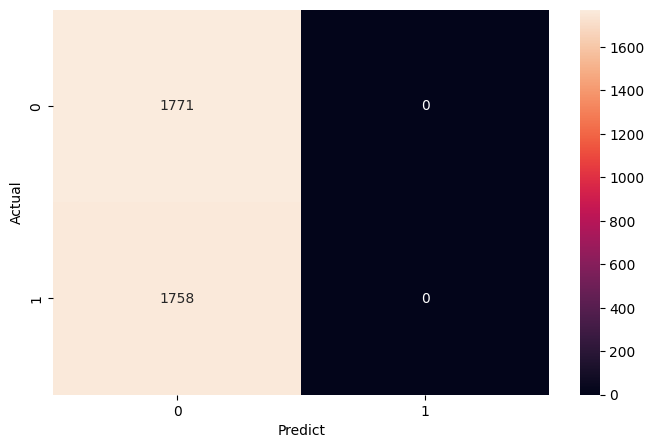

In [31]:
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test, y_predict), annot=True, fmt=".0f", ax=ax)
plt.xlabel("Predict")
plt.ylabel("Actual")
plt.show()

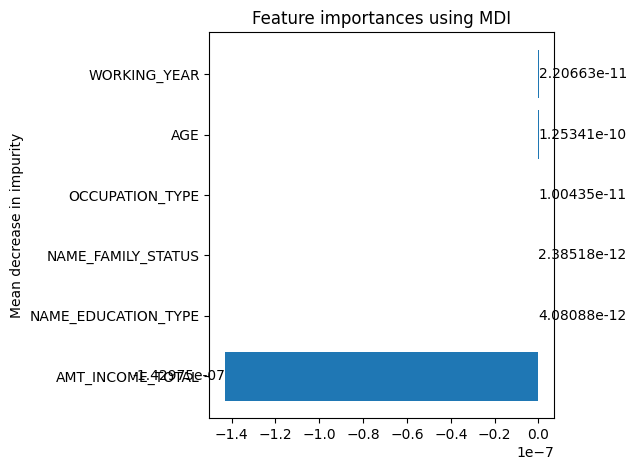

In [32]:
feature_names = X_res.columns
importances = model1.coef_[0]
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
bars = ax.barh(feature_names, forest_importances)
ax.bar_label(bars)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

#### Metode K-fold pada Logistic Regression

In [33]:
cross_val_score (model1, X_res, y_res, cv=6)

array([0.49982999, 0.49982999, 0.50017001, 0.50017001, 0.5       ,
       0.5       ])

In [34]:
cross_val_score (model1, X_res, y_res, cv=6).mean()

0.5

In [35]:
y_pred = cross_val_predict (model1, X_res, y_res, cv=5)

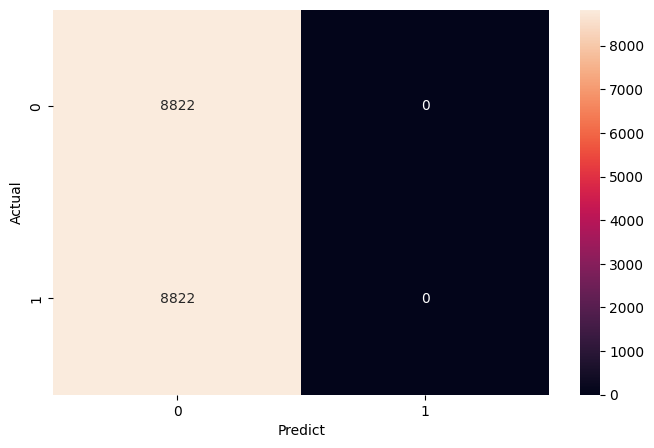

In [36]:
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_res, y_pred), annot=True, fmt=".0f", ax=ax)
plt.xlabel("Predict")
plt.ylabel("Actual")
plt.show()

#### MODEL 2 -- DECISION TREE

In [37]:
model2 = DecisionTreeClassifier(random_state=125)
model2.fit(X_train, y_train)
y_predict2 = model2.predict(X_test)
print('Accuracy Score is' ,accuracy_score(y_test,y_predict2))

Accuracy Score is 0.9348257296684613


In [38]:
print(classification_report(y_test, y_predict2))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      1771
           1       1.00      0.87      0.93      1758

    accuracy                           0.93      3529
   macro avg       0.94      0.93      0.93      3529
weighted avg       0.94      0.93      0.93      3529



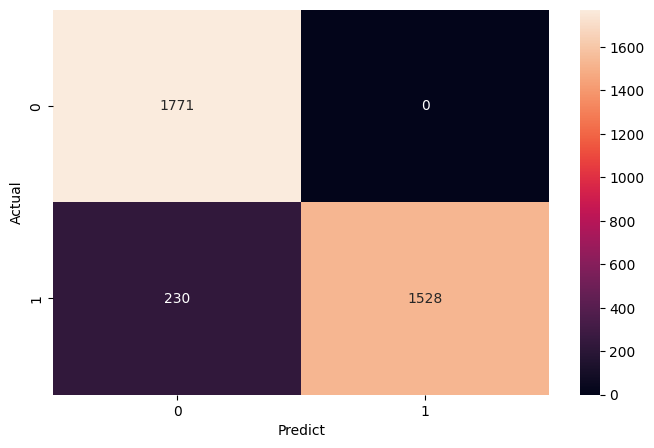

In [39]:
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test, y_predict2), annot=True, fmt=".0f", ax=ax)
plt.xlabel("Predict")
plt.ylabel("Actual")
plt.show()

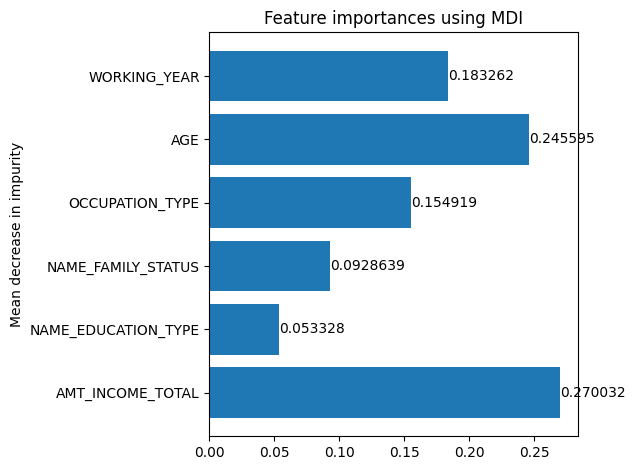

In [40]:
feature_names = X_res.columns
importances = model2.feature_importances_
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
bars = ax.barh(feature_names, forest_importances)
ax.bar_label(bars)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

#### Metode K-fold pada Decision Tree

In [41]:
cross_val_score (model2, X_res, y_res, cv=6)

array([0.92689561, 0.93471608, 0.92553553, 0.94015641, 0.93571429,
       0.92755102])

In [42]:
cross_val_score (model2, X_res, y_res, cv=6).mean()

0.9317614907234569

In [43]:
y_pred2 = cross_val_predict (model2, X_res, y_res, cv=5)

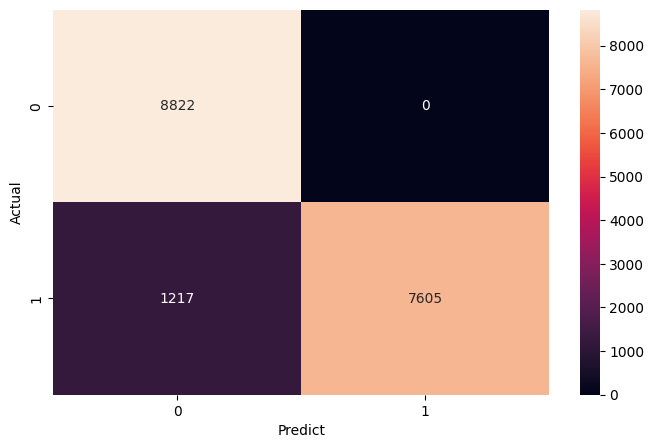

In [44]:
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_res, y_pred2), annot=True, fmt=".0f", ax=ax)
plt.xlabel("Predict")
plt.ylabel("Actual")
plt.show()

#### MODEL 3 -- RANDOM FOREST

In [45]:
model3 = RandomForestClassifier(random_state=125)
model3.fit(X_train, y_train)
y_predict3 = model3.predict(X_test)
print('Accuracy Score is' ,accuracy_score(y_test,y_predict3))

Accuracy Score is 0.9682629640124681


In [46]:
print(classification_report(y_test, y_predict3))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1771
           1       1.00      0.94      0.97      1758

    accuracy                           0.97      3529
   macro avg       0.97      0.97      0.97      3529
weighted avg       0.97      0.97      0.97      3529



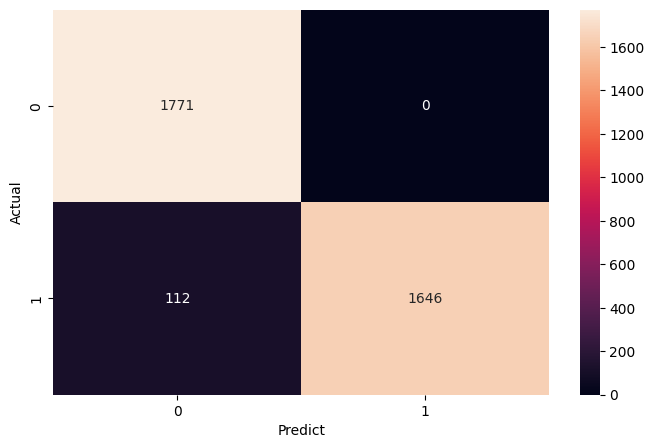

In [47]:
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test, y_predict3), annot=True, fmt=".0f", ax=ax)
plt.xlabel("Predict")
plt.ylabel("Actual")
plt.show()

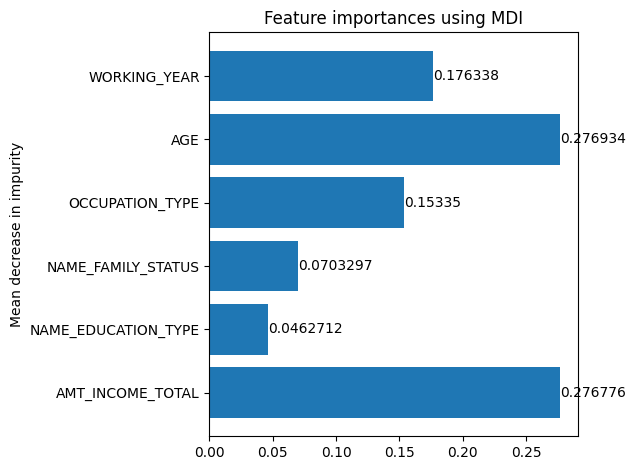

In [48]:
feature_names = X_res.columns
importances = model3.feature_importances_
std = np.std([tree.feature_importances_ for tree in model3.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
bars = ax.barh(feature_names, forest_importances)
ax.bar_label(bars)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

#### Metode K-fold pada Random Forest

In [49]:
cross_val_score (model3, X_res, y_res, cv=6)

array([0.95443727, 0.96803808, 0.95375723, 0.96871812, 0.96564626,
       0.96156463])

In [50]:
cross_val_score (model3, X_res, y_res, cv=6).mean()

0.9620269302325939

In [51]:
y_pred3 = cross_val_predict (model3, X_res, y_res, cv=5)

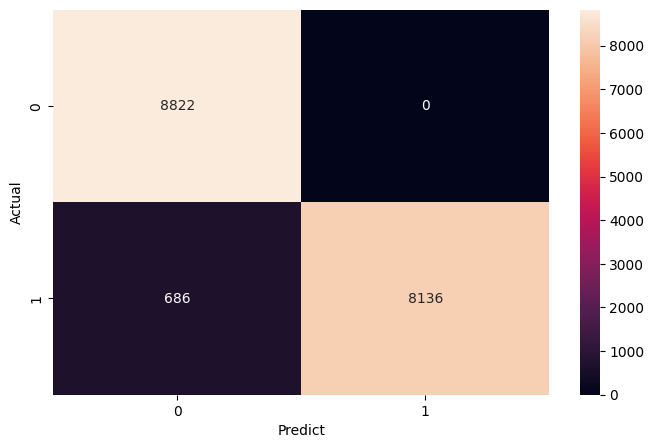

In [52]:
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_res, y_pred3), annot=True, fmt=".0f", ax=ax)
plt.xlabel("Predict")
plt.ylabel("Actual")
plt.show()

### SAVE MODEL

In [53]:
filename = 'credit_model.sav'
pickle.dump(model3,open(filename, 'wb'))